# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import math
import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**: Both of the network types uses activation functions and linear layers and possess hidden layers. The biggest difference between CNNs and RNNs is the fact that RNNs have loops which allow to introduce a memory structure that can exploit the connection between consequent data points.


**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**:  Using LSTMs can be a good start to reduce the risk of having vanishing or exploding gradients while sustaning the long term dependicies. However, these problem can still happen in LSTMs. Reducing batch size, using Gradient clipping or using a network with lower number of layers can be additionally used against these problems. However, it should be considered that these solutions, except gradient clipping, have effect on memory.



**Feedback (1):** Thanks for the resources, they were really helpful to implement the code below. We spent less than 1 hour to solve this part.

## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        # initialize required parameters / layers
        self.sigmoid = nn.Sigmoid()
        
        self.w_f = Parameter(torch.Tensor(hidden_size, hidden_size + input_size ))
        self.w_i = Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        self.w_c = Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        self.w_o = Parameter(torch.Tensor(hidden_size, hidden_size + input_size))
        
        self.b_f = Parameter(torch.Tensor(hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        self.b_c = Parameter(torch.Tensor(hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))
        
        # As it is done in Linear Layer source code
        stdv = 1. / math.sqrt(self.w_f.size(1))
        self.w_f.data.uniform_(-stdv, stdv)
        self.w_i.data.uniform_(-stdv, stdv)
        self.w_c.data.uniform_(-stdv, stdv)
        self.w_o.data.uniform_(-stdv, stdv)
        
        self.b_f.data.uniform_(-stdv, stdv)
        self.b_i.data.uniform_(-stdv, stdv)
        self.b_c.data.uniform_(-stdv, stdv)
        self.b_o.data.uniform_(-stdv, stdv)
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        Implemented directly from : http://colah.github.io/posts/2015-08-Understanding-LSTMs
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        #print(f"epoch (epoch)")
        if hx is None:
            hx = self._init_hidden_state(x)
        hidden_state, internal_state = hx
        
        # START TODO #############
        
        stacked_h_x = torch.cat([hidden_state,x],1)
        
        f_t = F.sigmoid(F.linear(stacked_h_x,self.w_f,self.b_f ))
        
        i_t = F.sigmoid(F.linear(stacked_h_x,self.w_i,self.b_i ))
        
        C_til = F.tanh(F.linear(stacked_h_x,self.w_c,self.b_c ))
        
        C_t = f_t * internal_state + i_t * C_til
        
        o_t = F.sigmoid(F.linear(stacked_h_x,self.w_o,self.b_o ))
        
        h_t = o_t * F.tanh(C_t)
        

        return h_t, C_t
    
        # END TODO #############
        
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        # START TODO #############
        initial_hidden_state = torch.zeros(x.shape[0], self.hidden_size)
        initial_cell_state =  torch.zeros(x.shape[0], self.hidden_size)
        return (initial_hidden_state, initial_cell_state)
        #raise NotImplementedError
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)
        # START TODO #############
        # iterate over the sequence and apply the LSTM
        seq_len = x.shape[0]
        output_stacked_hidden = []
        
        for i in range(seq_len):
            hx = super(LSTM, self).forward(x[i,:,:], hx)
            hidden_state, internal_state = hx
            output_stacked_hidden.append(hidden_state)
          
        return (torch.stack(output_stacked_hidden), (hidden_state, internal_state))
        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0, loss:1.5256271362304688
test accuracy: 0.0
epoch: 10, loss:0.2540116310119629
test accuracy: 0.07
epoch: 20, loss:0.11323864012956619
test accuracy: 0.17
epoch: 30, loss:0.012755494564771652
test accuracy: 0.2
epoch: 40, loss:0.014789676293730736
test accuracy: 0.32
epoch: 50, loss:0.005776790902018547
test accuracy: 0.57
epoch: 60, loss:0.002657288685441017
test accuracy: 0.66
epoch: 70, loss:0.0018434191588312387
test accuracy: 0.8
epoch: 80, loss:0.002171036321669817
test accuracy: 0.83
epoch: 90, loss:0.0006199331837706268
test accuracy: 0.96
epoch: 100, loss:0.00037805340252816677
test accuracy: 0.96


**Feedback (2):** It was really hard to do this part. We spent more than 2 days to solve it. It was a great hustle to implement something on the paper to the code. Nonetheless, we have learned a lot from the process.

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

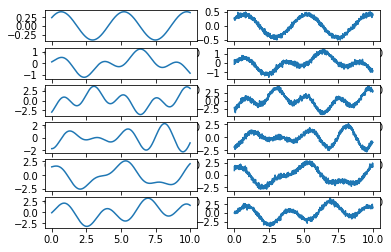

In [5]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
sines = sample_sine_functions(6)
#a=RandomSineFunction()
#sines[0](1)
#noisy(sines[1])
t = np.arange(0.0, 10.0, 0.01)
for i in range(len(sines)):
   # normals[i] = sines[i](t)
    #noised[i] = noisy(sines[i](t))
    plt.subplot(len(sines),2,2*i+1)
    plt.plot(t, sines[i](t))
    plt.subplot(len(sines),2,2*i+2)
    plt.plot(t, noisy(sines[i](t)))
plt.show()
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (sequence_length, batch_size, hidden_size) followed by a Linear layer which takes a (sequence_length, batch_size, hidden_size) vector as input and outputs a tensor with shape (sequence_length, batch_size, 1).


To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [6]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        # START TODO #############
        
        self.hidden_size = hidden_size
        
        self.lstm1 = LSTM(input_size=1,hidden_size=hidden_size)
        self.lstm2 = LSTM(input_size=40,hidden_size=hidden_size)
        self.linear = nn.Linear(hidden_size,1)
        
       # (sequence_length, batch_size, hidden_size)
        
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.interval zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        
        sequence_length = x.shape[0]
        batch_size = x.shape[1]
        hidden_size = self.hidden_size
        
        
        
        #1) pads the input sequence with self.interval zeros at the end,
        #print(x.shape)
        x = torch.from_numpy(np.pad(x,((0,self.shift),(0,0),(0,0)),mode='constant', constant_values=(0) ))
        
        #2) applies an LSTM
        #(sequence_length, batch_size, hidden_size)
 
        #print(x.shape)
        out1,hidden = self.lstm1(x)
        #print(out1.shape)
        #3) cuts the first self.interval outputs
        
        out1 = out1[self.shift:]
        #print(out1.shape)
        #4) applies another LSTM
                   
        out1,hidden = self.lstm2(out1,hidden)     
                   
        #5) applies Linear layer.
        
        out = self.linear(out1)
        #print(out.shape)
        return torch.Tensor(out)
        
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        #raise NotImplementedError
        # END TODO #############
        

In [7]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

print(train_sequences.shape)

torch.Size([80, 200, 1])


In [8]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    for epoch in range(num_epochs):
        # START TODO #############
        for batch_idx in range(num_functions // batch_size):
            optimizer.zero_grad()
            batch = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            out = model(batch)
            loss = loss_fn(train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size], out)
            loss.backward()
            optimizer.step()
    
        # END TODO #############
        print(f"epoch: {epoch}, train loss:{loss}")
        
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:506.8393249511719
epoch: 0, validation loss:1450.3536376953125


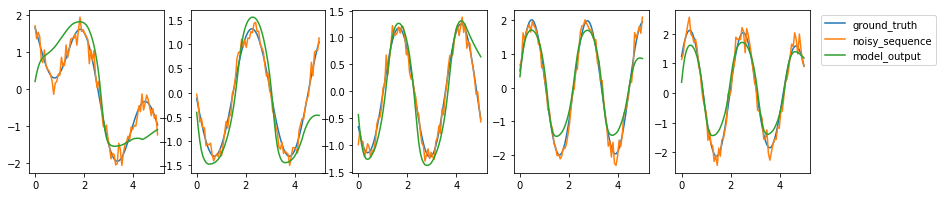

-289.9462% of noise removed.
epoch: 1, train loss:196.67185974121094
epoch: 1, validation loss:438.05438232421875
epoch: 2, train loss:89.77854919433594
epoch: 2, validation loss:245.9946746826172
epoch: 3, train loss:60.51059341430664
epoch: 3, validation loss:265.2489013671875
epoch: 4, train loss:74.15589904785156
epoch: 4, validation loss:195.99981689453125
epoch: 5, train loss:53.94382095336914
epoch: 5, validation loss:184.40475463867188
epoch: 6, train loss:48.50090026855469
epoch: 6, validation loss:156.0416259765625
epoch: 7, train loss:45.0393180847168
epoch: 7, validation loss:133.0910186767578
epoch: 8, train loss:45.08787536621094
epoch: 8, validation loss:127.5869140625
epoch: 9, train loss:32.44717788696289
epoch: 9, validation loss:134.52049255371094
epoch: 10, train loss:29.174253463745117
epoch: 10, validation loss:111.1767807006836


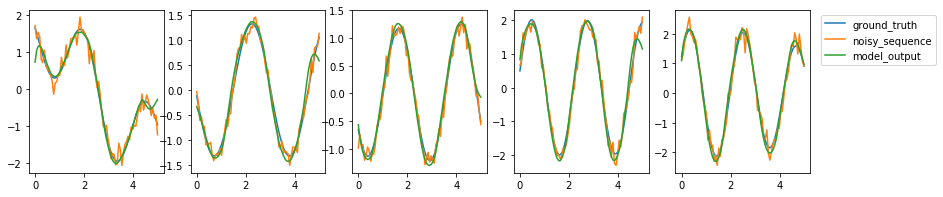

9.2964% of noise removed.
epoch: 11, train loss:24.41680145263672
epoch: 11, validation loss:118.23365020751953
epoch: 12, train loss:24.48461151123047
epoch: 12, validation loss:112.17696380615234
epoch: 13, train loss:23.255443572998047
epoch: 13, validation loss:107.2943344116211
epoch: 14, train loss:22.319942474365234
epoch: 14, validation loss:105.2287826538086
epoch: 15, train loss:20.861963272094727
epoch: 15, validation loss:94.59785461425781
epoch: 16, train loss:19.216960906982422
epoch: 16, validation loss:86.05003356933594
epoch: 17, train loss:17.592998504638672
epoch: 17, validation loss:78.3329086303711
epoch: 18, train loss:16.050600051879883
epoch: 18, validation loss:71.39820098876953
epoch: 19, train loss:14.970988273620605
epoch: 19, validation loss:66.18619537353516
epoch: 20, train loss:14.538139343261719
epoch: 20, validation loss:62.21389389038086


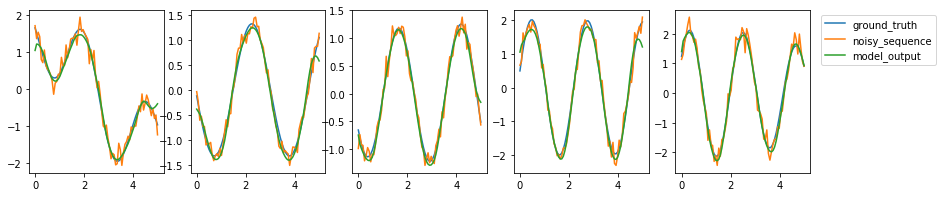

36.3551% of noise removed.
epoch: 21, train loss:14.431957244873047
epoch: 21, validation loss:60.053707122802734
epoch: 22, train loss:13.852287292480469
epoch: 22, validation loss:63.864933013916016
epoch: 23, train loss:12.577204704284668
epoch: 23, validation loss:71.78318786621094
epoch: 24, train loss:12.507128715515137
epoch: 24, validation loss:71.37702178955078
epoch: 25, train loss:11.626702308654785
epoch: 25, validation loss:63.30529022216797
epoch: 26, train loss:9.496919631958008
epoch: 26, validation loss:62.5726432800293
epoch: 27, train loss:8.672809600830078
epoch: 27, validation loss:54.50480651855469
epoch: 28, train loss:9.822449684143066
epoch: 28, validation loss:63.217247009277344
epoch: 29, train loss:9.46137809753418
epoch: 29, validation loss:47.19125747680664
epoch: 30, train loss:11.198976516723633
epoch: 30, validation loss:68.16354370117188


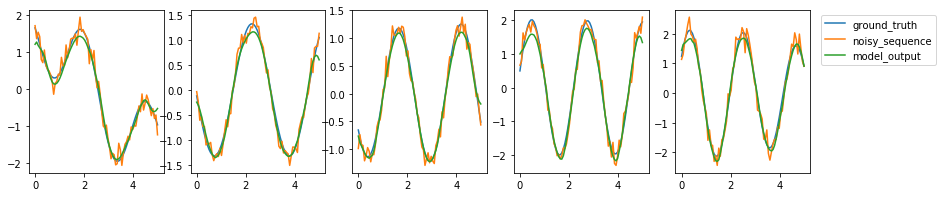

30.9925% of noise removed.
epoch: 31, train loss:9.802486419677734
epoch: 31, validation loss:52.62602615356445
epoch: 32, train loss:10.650066375732422
epoch: 32, validation loss:66.03555297851562
epoch: 33, train loss:7.519448280334473
epoch: 33, validation loss:62.7570915222168
epoch: 34, train loss:8.342803001403809
epoch: 34, validation loss:70.34156799316406
epoch: 35, train loss:11.692387580871582
epoch: 35, validation loss:58.00680923461914
epoch: 36, train loss:19.131786346435547
epoch: 36, validation loss:49.43171310424805
epoch: 37, train loss:11.720623016357422
epoch: 37, validation loss:51.97562789916992
epoch: 38, train loss:8.860308647155762
epoch: 38, validation loss:47.87058639526367
epoch: 39, train loss:7.628943920135498
epoch: 39, validation loss:45.14759826660156
epoch: 40, train loss:7.279702186584473
epoch: 40, validation loss:42.37495040893555


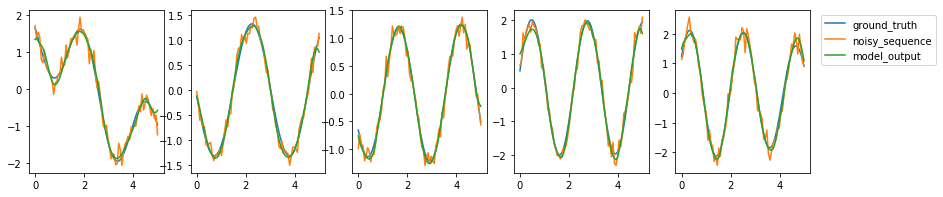

43.1948% of noise removed.
epoch: 41, train loss:7.323150634765625
epoch: 41, validation loss:40.55258560180664
epoch: 42, train loss:6.166191101074219
epoch: 42, validation loss:38.73511505126953
epoch: 43, train loss:6.144979000091553
epoch: 43, validation loss:38.88417434692383
epoch: 44, train loss:6.313414573669434
epoch: 44, validation loss:39.711246490478516
epoch: 45, train loss:6.743423938751221
epoch: 45, validation loss:41.741458892822266
epoch: 46, train loss:7.336831092834473
epoch: 46, validation loss:47.0024299621582
epoch: 47, train loss:7.740224361419678
epoch: 47, validation loss:57.469261169433594
epoch: 48, train loss:5.786855697631836
epoch: 48, validation loss:58.30901336669922
epoch: 49, train loss:4.854220867156982
epoch: 49, validation loss:37.651611328125
epoch: 50, train loss:4.26955509185791
epoch: 50, validation loss:34.75209045410156


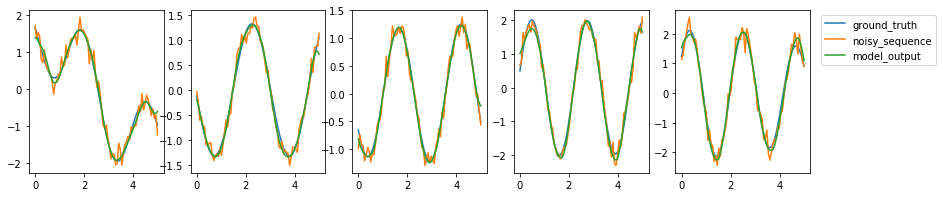

50.0845% of noise removed.
epoch: 51, train loss:4.428982257843018
epoch: 51, validation loss:36.929561614990234
epoch: 52, train loss:4.762487888336182
epoch: 52, validation loss:35.056968688964844
epoch: 53, train loss:4.440711498260498
epoch: 53, validation loss:35.68274688720703
epoch: 54, train loss:4.291403293609619
epoch: 54, validation loss:36.63853454589844
epoch: 55, train loss:4.028443813323975
epoch: 55, validation loss:37.7332878112793
epoch: 56, train loss:3.850327491760254
epoch: 56, validation loss:37.63225555419922
epoch: 57, train loss:3.6290459632873535
epoch: 57, validation loss:37.20977783203125
epoch: 58, train loss:3.538924217224121
epoch: 58, validation loss:36.524349212646484
epoch: 59, train loss:3.5938143730163574
epoch: 59, validation loss:36.87419128417969
epoch: 60, train loss:3.5009584426879883
epoch: 60, validation loss:38.71648025512695


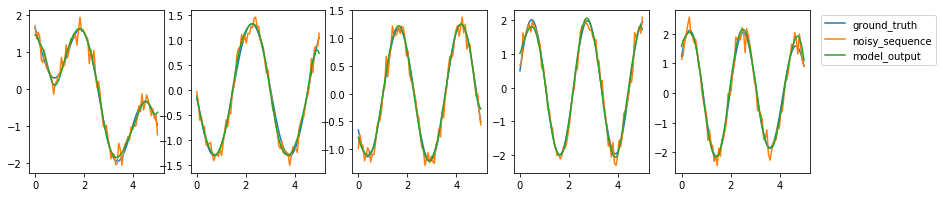

46.5775% of noise removed.
epoch: 61, train loss:3.5808615684509277
epoch: 61, validation loss:42.223167419433594
epoch: 62, train loss:3.5045745372772217
epoch: 62, validation loss:46.17670822143555
epoch: 63, train loss:3.6297643184661865
epoch: 63, validation loss:48.22484588623047
epoch: 64, train loss:3.731579065322876
epoch: 64, validation loss:45.186790466308594
epoch: 65, train loss:3.9002022743225098
epoch: 65, validation loss:39.35908508300781
epoch: 66, train loss:3.518280267715454
epoch: 66, validation loss:37.25150680541992
epoch: 67, train loss:3.3516979217529297
epoch: 67, validation loss:39.111629486083984
epoch: 68, train loss:3.2717199325561523
epoch: 68, validation loss:43.43683624267578
epoch: 69, train loss:3.318514108657837
epoch: 69, validation loss:49.59907150268555
epoch: 70, train loss:3.0999271869659424
epoch: 70, validation loss:55.553401947021484


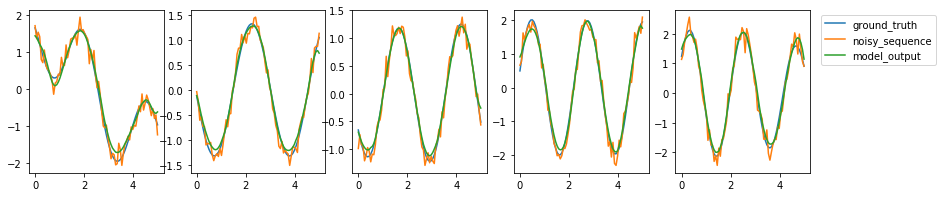

33.9877% of noise removed.
epoch: 71, train loss:2.853327751159668
epoch: 71, validation loss:49.93592834472656
epoch: 72, train loss:3.406161069869995
epoch: 72, validation loss:34.4978141784668
epoch: 73, train loss:3.415102958679199
epoch: 73, validation loss:30.492008209228516
epoch: 74, train loss:2.9804563522338867
epoch: 74, validation loss:30.42091178894043
epoch: 75, train loss:3.0039114952087402
epoch: 75, validation loss:30.384340286254883
epoch: 76, train loss:3.006899356842041
epoch: 76, validation loss:30.3563175201416
epoch: 77, train loss:2.9902894496917725
epoch: 77, validation loss:30.638965606689453
epoch: 78, train loss:2.8318052291870117
epoch: 78, validation loss:30.95631217956543
epoch: 79, train loss:2.628945827484131
epoch: 79, validation loss:30.607908248901367
epoch: 80, train loss:2.5166168212890625
epoch: 80, validation loss:30.162900924682617


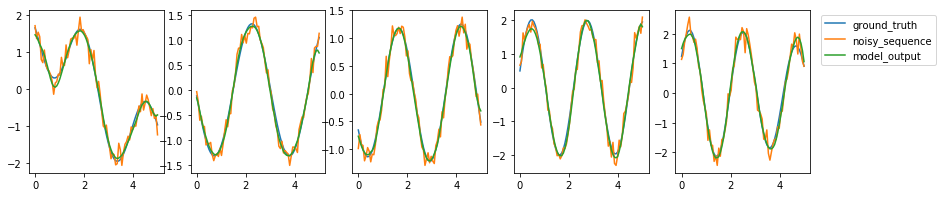

52.6794% of noise removed.
epoch: 81, train loss:2.4929044246673584
epoch: 81, validation loss:30.17936897277832
epoch: 82, train loss:2.4772634506225586
epoch: 82, validation loss:30.45890998840332
epoch: 83, train loss:2.4597954750061035
epoch: 83, validation loss:30.859376907348633
epoch: 84, train loss:2.4406449794769287
epoch: 84, validation loss:31.21766471862793
epoch: 85, train loss:2.4124433994293213
epoch: 85, validation loss:31.232393264770508
epoch: 86, train loss:2.3877203464508057
epoch: 86, validation loss:30.717254638671875
epoch: 87, train loss:2.3915374279022217
epoch: 87, validation loss:29.88177490234375
epoch: 88, train loss:2.409897804260254
epoch: 88, validation loss:29.218589782714844
epoch: 89, train loss:2.4085564613342285
epoch: 89, validation loss:28.896366119384766
epoch: 90, train loss:2.3981263637542725
epoch: 90, validation loss:28.760051727294922


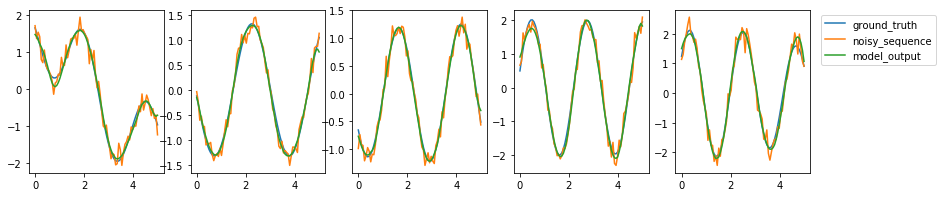

54.1048% of noise removed.
epoch: 91, train loss:2.397552251815796
epoch: 91, validation loss:28.70115089416504
epoch: 92, train loss:2.3970346450805664
epoch: 92, validation loss:28.689661026000977
epoch: 93, train loss:2.3907856941223145
epoch: 93, validation loss:28.654386520385742
epoch: 94, train loss:2.386937141418457
epoch: 94, validation loss:28.62385368347168
epoch: 95, train loss:2.383999824523926
epoch: 95, validation loss:28.604856491088867
epoch: 96, train loss:2.3823180198669434
epoch: 96, validation loss:28.59192657470703
epoch: 97, train loss:2.380736827850342
epoch: 97, validation loss:28.583005905151367
epoch: 98, train loss:2.3796658515930176
epoch: 98, validation loss:28.57733917236328
epoch: 99, train loss:2.378910541534424
epoch: 99, validation loss:28.57398796081543
epoch: 100, train loss:2.3784019947052
epoch: 100, validation loss:28.5723819732666


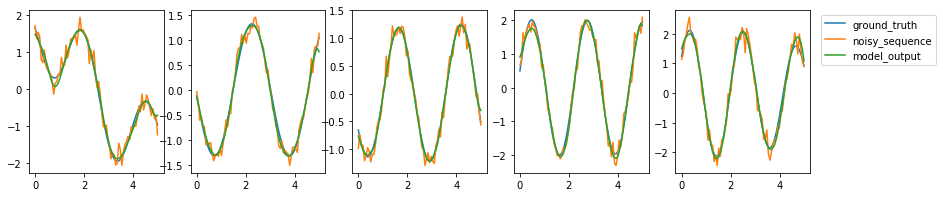

54.2089% of noise removed.


In [9]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration                 | Noise removed in percent    |  
| --------------------          | --------------------------: |
| initial configuration         | 54.21% ( not 32.52%)        |
| batch size: 20                | 52.52%                         |
| batch size: 5, num_epoch:140  | 55.60%                      |
| lr = 0.3                      | 55.78%                      |

epoch: 0, train loss:1015.864501953125
epoch: 0, validation loss:1409.6356201171875


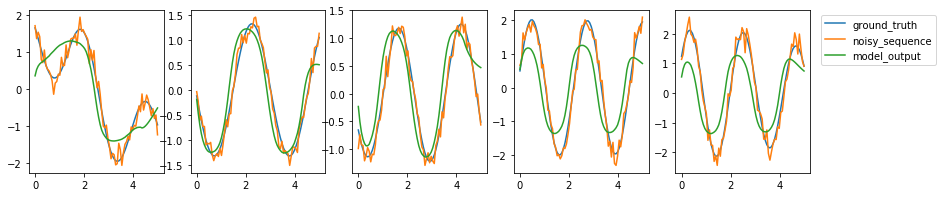

-268.6444% of noise removed.
epoch: 1, train loss:819.9009399414062
epoch: 1, validation loss:1140.81689453125
epoch: 2, train loss:507.23291015625
epoch: 2, validation loss:681.6183471679688
epoch: 3, train loss:294.0276184082031
epoch: 3, validation loss:516.1224365234375
epoch: 4, train loss:212.12142944335938
epoch: 4, validation loss:341.5788879394531
epoch: 5, train loss:157.18350219726562
epoch: 5, validation loss:212.12423706054688
epoch: 6, train loss:114.78581237792969
epoch: 6, validation loss:155.57745361328125
epoch: 7, train loss:88.24061584472656
epoch: 7, validation loss:142.99490356445312
epoch: 8, train loss:75.01544952392578
epoch: 8, validation loss:130.9395294189453
epoch: 9, train loss:69.68314361572266
epoch: 9, validation loss:125.81378936767578
epoch: 10, train loss:66.5632095336914
epoch: 10, validation loss:123.12063598632812


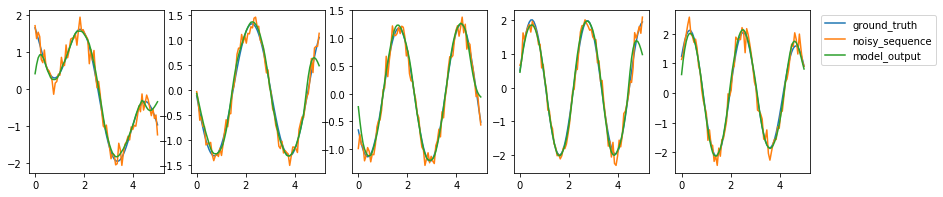

21.3796% of noise removed.
epoch: 11, train loss:68.66609191894531
epoch: 11, validation loss:136.88104248046875
epoch: 12, train loss:54.26368713378906
epoch: 12, validation loss:113.57820129394531
epoch: 13, train loss:57.334083557128906
epoch: 13, validation loss:106.0614242553711
epoch: 14, train loss:51.88373947143555
epoch: 14, validation loss:104.47358703613281
epoch: 15, train loss:50.90049743652344
epoch: 15, validation loss:108.31558990478516
epoch: 16, train loss:53.39600372314453
epoch: 16, validation loss:121.32097625732422
epoch: 17, train loss:51.49545669555664
epoch: 17, validation loss:143.98777770996094
epoch: 18, train loss:42.888465881347656
epoch: 18, validation loss:92.90606689453125
epoch: 19, train loss:44.88871765136719
epoch: 19, validation loss:81.18933868408203
epoch: 20, train loss:35.82155227661133
epoch: 20, validation loss:73.12567138671875


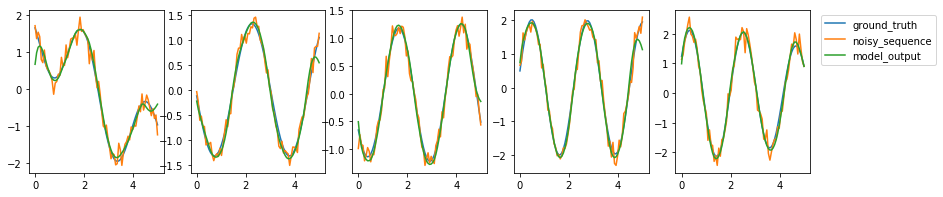

38.3985% of noise removed.
epoch: 21, train loss:33.842559814453125
epoch: 21, validation loss:79.4465560913086
epoch: 22, train loss:32.3474006652832
epoch: 22, validation loss:98.95722198486328
epoch: 23, train loss:32.08932876586914
epoch: 23, validation loss:103.27342987060547
epoch: 24, train loss:30.57648277282715
epoch: 24, validation loss:91.6155776977539
epoch: 25, train loss:29.673093795776367
epoch: 25, validation loss:72.531494140625
epoch: 26, train loss:28.60144805908203
epoch: 26, validation loss:68.41619873046875
epoch: 27, train loss:27.909521102905273
epoch: 27, validation loss:70.9397201538086
epoch: 28, train loss:26.579362869262695
epoch: 28, validation loss:68.93221282958984
epoch: 29, train loss:26.103391647338867
epoch: 29, validation loss:60.206764221191406
epoch: 30, train loss:24.614126205444336
epoch: 30, validation loss:58.125732421875


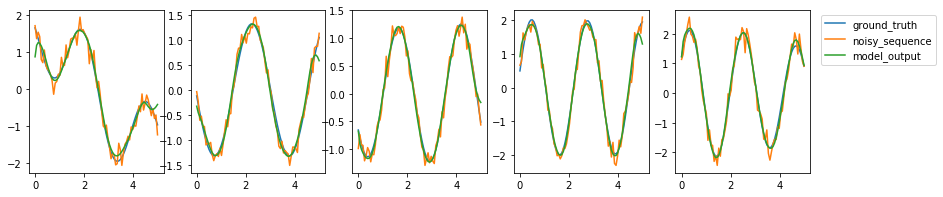

43.6333% of noise removed.
epoch: 31, train loss:24.301612854003906
epoch: 31, validation loss:59.976226806640625
epoch: 32, train loss:23.509098052978516
epoch: 32, validation loss:63.625587463378906
epoch: 33, train loss:23.141138076782227
epoch: 33, validation loss:65.23755645751953
epoch: 34, train loss:22.970693588256836
epoch: 34, validation loss:70.83770751953125
epoch: 35, train loss:22.009502410888672
epoch: 35, validation loss:62.29496383666992
epoch: 36, train loss:21.87372398376465
epoch: 36, validation loss:56.828521728515625
epoch: 37, train loss:21.04576301574707
epoch: 37, validation loss:51.94316864013672
epoch: 38, train loss:20.178348541259766
epoch: 38, validation loss:50.614112854003906
epoch: 39, train loss:19.276548385620117
epoch: 39, validation loss:49.494266510009766
epoch: 40, train loss:18.54442024230957
epoch: 40, validation loss:47.202171325683594


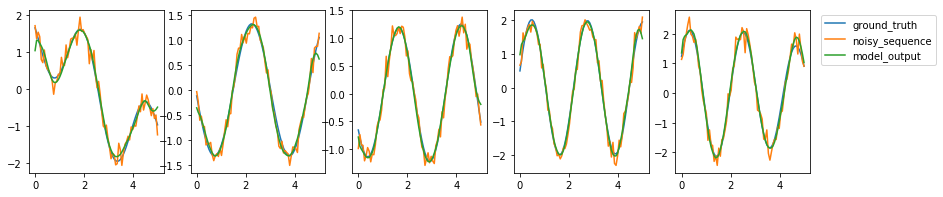

46.5202% of noise removed.
epoch: 41, train loss:17.883567810058594
epoch: 41, validation loss:46.84165573120117
epoch: 42, train loss:17.654565811157227
epoch: 42, validation loss:47.17597198486328
epoch: 43, train loss:17.20872688293457
epoch: 43, validation loss:46.181884765625
epoch: 44, train loss:16.955902099609375
epoch: 44, validation loss:43.89710998535156
epoch: 45, train loss:16.828773498535156
epoch: 45, validation loss:43.066261291503906
epoch: 46, train loss:16.68079376220703
epoch: 46, validation loss:41.819156646728516
epoch: 47, train loss:17.118934631347656
epoch: 47, validation loss:40.6318359375
epoch: 48, train loss:16.968242645263672
epoch: 48, validation loss:43.00346374511719
epoch: 49, train loss:17.167499542236328
epoch: 49, validation loss:40.224327087402344
epoch: 50, train loss:16.84902572631836
epoch: 50, validation loss:40.61820602416992


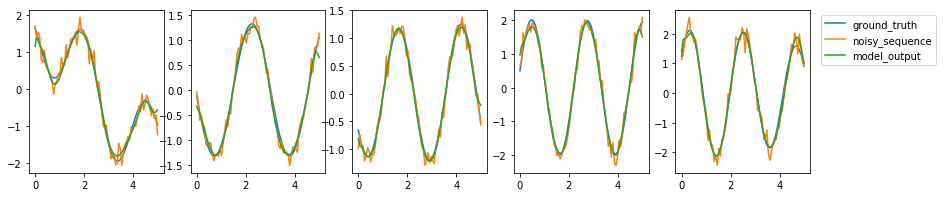

47.6283% of noise removed.
epoch: 51, train loss:16.50031280517578
epoch: 51, validation loss:43.415321350097656
epoch: 52, train loss:19.005348205566406
epoch: 52, validation loss:54.451080322265625
epoch: 53, train loss:21.807308197021484
epoch: 53, validation loss:80.74835205078125
epoch: 54, train loss:22.86716079711914
epoch: 54, validation loss:86.8287124633789
epoch: 55, train loss:20.39715576171875
epoch: 55, validation loss:42.04189682006836
epoch: 56, train loss:15.605376243591309
epoch: 56, validation loss:38.30897521972656
epoch: 57, train loss:16.910675048828125
epoch: 57, validation loss:39.64924240112305
epoch: 58, train loss:17.054851531982422
epoch: 58, validation loss:45.539573669433594
epoch: 59, train loss:15.723840713500977
epoch: 59, validation loss:40.38998031616211
epoch: 60, train loss:14.973237991333008
epoch: 60, validation loss:42.139251708984375


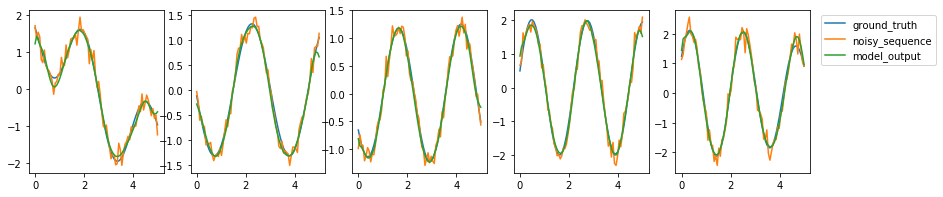

43.8922% of noise removed.
epoch: 61, train loss:15.450974464416504
epoch: 61, validation loss:44.04207992553711
epoch: 62, train loss:13.971220016479492
epoch: 62, validation loss:41.56135559082031
epoch: 63, train loss:13.504889488220215
epoch: 63, validation loss:42.366424560546875
epoch: 64, train loss:13.203394889831543
epoch: 64, validation loss:39.70050811767578
epoch: 65, train loss:12.855871200561523
epoch: 65, validation loss:37.17483901977539
epoch: 66, train loss:13.416533470153809
epoch: 66, validation loss:34.90107727050781
epoch: 67, train loss:13.359535217285156
epoch: 67, validation loss:34.964691162109375
epoch: 68, train loss:12.981411933898926
epoch: 68, validation loss:34.55731201171875
epoch: 69, train loss:12.659463882446289
epoch: 69, validation loss:34.95330047607422
epoch: 70, train loss:12.505010604858398
epoch: 70, validation loss:35.62438201904297


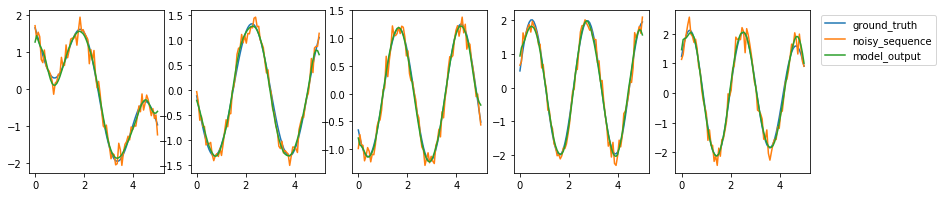

49.2045% of noise removed.
epoch: 71, train loss:12.486956596374512
epoch: 71, validation loss:36.67622756958008
epoch: 72, train loss:12.565263748168945
epoch: 72, validation loss:37.6051025390625
epoch: 73, train loss:12.379887580871582
epoch: 73, validation loss:38.6104736328125
epoch: 74, train loss:12.104208946228027
epoch: 74, validation loss:39.29008483886719
epoch: 75, train loss:11.629096984863281
epoch: 75, validation loss:38.453369140625
epoch: 76, train loss:11.491476058959961
epoch: 76, validation loss:36.49275207519531
epoch: 77, train loss:11.602280616760254
epoch: 77, validation loss:34.644508361816406
epoch: 78, train loss:11.714716911315918
epoch: 78, validation loss:34.086204528808594
epoch: 79, train loss:11.56131362915039
epoch: 79, validation loss:34.13536834716797
epoch: 80, train loss:11.376659393310547
epoch: 80, validation loss:33.89072036743164


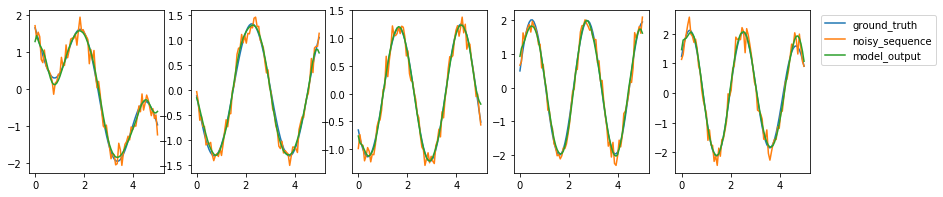

50.0025% of noise removed.
epoch: 81, train loss:11.247491836547852
epoch: 81, validation loss:33.05564880371094
epoch: 82, train loss:11.230792999267578
epoch: 82, validation loss:32.052852630615234
epoch: 83, train loss:11.161054611206055
epoch: 83, validation loss:31.7598876953125
epoch: 84, train loss:11.009201049804688
epoch: 84, validation loss:31.796669006347656
epoch: 85, train loss:10.9473876953125
epoch: 85, validation loss:31.885133743286133
epoch: 86, train loss:10.929646492004395
epoch: 86, validation loss:31.826496124267578
epoch: 87, train loss:10.918171882629395
epoch: 87, validation loss:31.741613388061523
epoch: 88, train loss:10.880280494689941
epoch: 88, validation loss:31.772794723510742
epoch: 89, train loss:10.854547500610352
epoch: 89, validation loss:31.74904441833496
epoch: 90, train loss:10.834638595581055
epoch: 90, validation loss:31.740264892578125


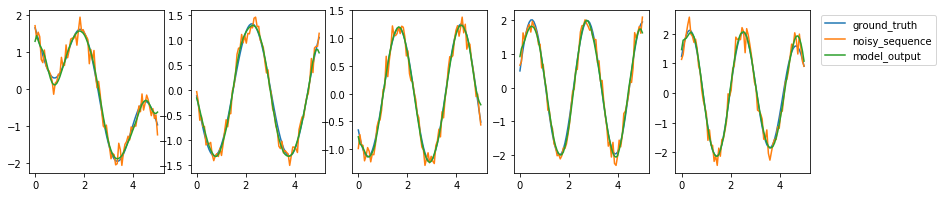

52.5027% of noise removed.
epoch: 91, train loss:10.818597793579102
epoch: 91, validation loss:31.735462188720703
epoch: 92, train loss:10.804901123046875
epoch: 92, validation loss:31.729923248291016
epoch: 93, train loss:10.793545722961426
epoch: 93, validation loss:31.723155975341797
epoch: 94, train loss:10.784106254577637
epoch: 94, validation loss:31.720659255981445
epoch: 95, train loss:10.776850700378418
epoch: 95, validation loss:31.716915130615234
epoch: 96, train loss:10.771096229553223
epoch: 96, validation loss:31.715003967285156
epoch: 97, train loss:10.766765594482422
epoch: 97, validation loss:31.713956832885742
epoch: 98, train loss:10.763700485229492
epoch: 98, validation loss:31.713220596313477
epoch: 99, train loss:10.761695861816406
epoch: 99, validation loss:31.71282196044922
epoch: 100, train loss:10.760544776916504
epoch: 100, validation loss:31.712663650512695


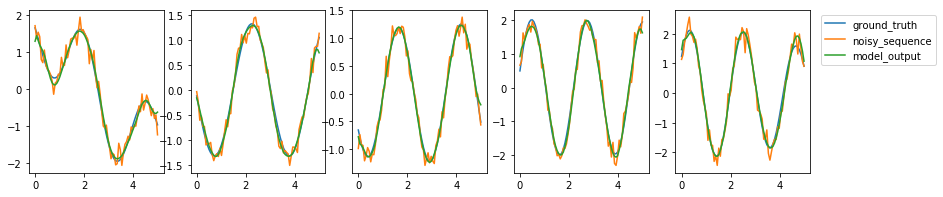

52.5195% of noise removed.
epoch: 0, train loss:96.86365509033203
epoch: 0, validation loss:351.1676330566406


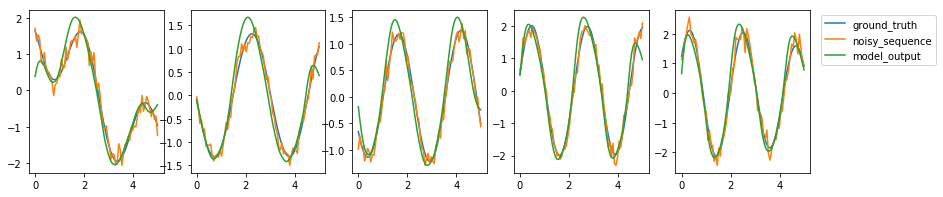

-66.4170% of noise removed.
epoch: 1, train loss:38.61111831665039
epoch: 1, validation loss:236.655517578125
epoch: 2, train loss:44.58916091918945
epoch: 2, validation loss:180.5475311279297
epoch: 3, train loss:59.25511169433594
epoch: 3, validation loss:158.04168701171875
epoch: 4, train loss:28.92992401123047
epoch: 4, validation loss:122.3072509765625
epoch: 5, train loss:23.294445037841797
epoch: 5, validation loss:117.6121826171875
epoch: 6, train loss:19.655197143554688
epoch: 6, validation loss:106.20018005371094
epoch: 7, train loss:70.60828399658203
epoch: 7, validation loss:182.32061767578125
epoch: 8, train loss:13.399873733520508
epoch: 8, validation loss:97.201904296875
epoch: 9, train loss:23.63711166381836
epoch: 9, validation loss:96.82965087890625
epoch: 10, train loss:14.945784568786621
epoch: 10, validation loss:125.7197036743164


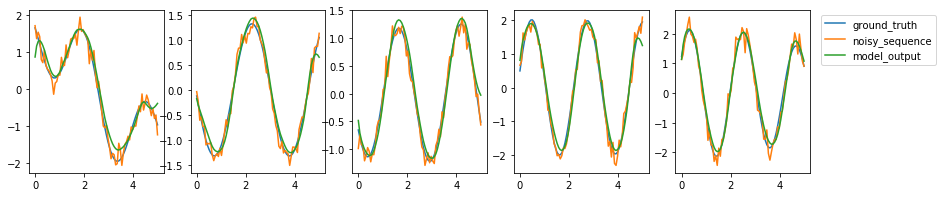

-5.8032% of noise removed.
epoch: 11, train loss:18.162433624267578
epoch: 11, validation loss:112.98775482177734
epoch: 12, train loss:21.757617950439453
epoch: 12, validation loss:93.25590515136719
epoch: 13, train loss:17.081022262573242
epoch: 13, validation loss:93.51526641845703
epoch: 14, train loss:13.1405611038208
epoch: 14, validation loss:100.00142669677734
epoch: 15, train loss:9.163398742675781
epoch: 15, validation loss:89.22962951660156
epoch: 16, train loss:12.318516731262207
epoch: 16, validation loss:71.45429229736328
epoch: 17, train loss:7.20755672454834
epoch: 17, validation loss:68.55301666259766
epoch: 18, train loss:10.053871154785156
epoch: 18, validation loss:70.36714172363281
epoch: 19, train loss:5.965304851531982
epoch: 19, validation loss:59.67448806762695
epoch: 20, train loss:8.228236198425293
epoch: 20, validation loss:54.985809326171875


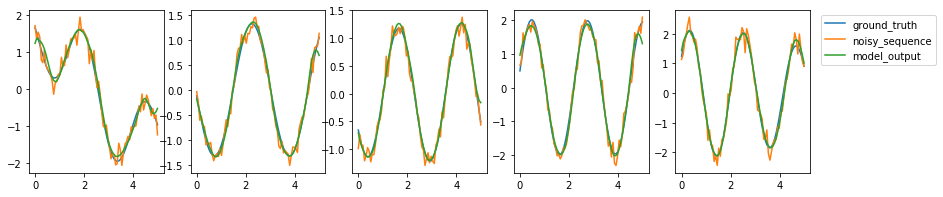

29.4901% of noise removed.
epoch: 21, train loss:7.80574893951416
epoch: 21, validation loss:68.89176177978516
epoch: 22, train loss:11.019623756408691
epoch: 22, validation loss:75.39633178710938
epoch: 23, train loss:14.108807563781738
epoch: 23, validation loss:70.79367065429688
epoch: 24, train loss:21.607145309448242
epoch: 24, validation loss:52.41998291015625
epoch: 25, train loss:6.596959114074707
epoch: 25, validation loss:53.51994705200195
epoch: 26, train loss:6.308865070343018
epoch: 26, validation loss:54.14811706542969
epoch: 27, train loss:6.103288650512695
epoch: 27, validation loss:42.613304138183594
epoch: 28, train loss:5.789284706115723
epoch: 28, validation loss:42.390872955322266
epoch: 29, train loss:5.894339561462402
epoch: 29, validation loss:40.87590026855469
epoch: 30, train loss:4.651538372039795
epoch: 30, validation loss:40.368900299072266


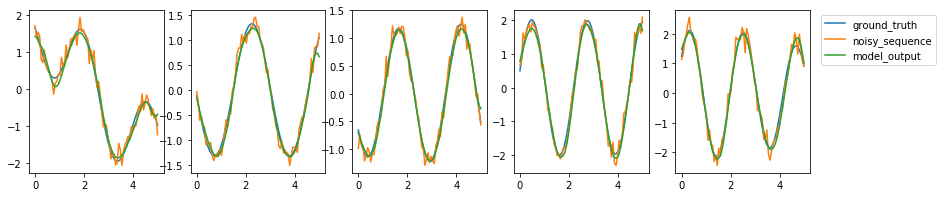

42.1091% of noise removed.
epoch: 31, train loss:4.600236892700195
epoch: 31, validation loss:40.157901763916016
epoch: 32, train loss:5.6728973388671875
epoch: 32, validation loss:39.269874572753906
epoch: 33, train loss:5.2418365478515625
epoch: 33, validation loss:40.143821716308594
epoch: 34, train loss:5.562105655670166
epoch: 34, validation loss:40.574546813964844
epoch: 35, train loss:5.702692985534668
epoch: 35, validation loss:41.922828674316406
epoch: 36, train loss:5.5093793869018555
epoch: 36, validation loss:44.50954818725586
epoch: 37, train loss:5.118295192718506
epoch: 37, validation loss:45.292903900146484
epoch: 38, train loss:4.655761241912842
epoch: 38, validation loss:47.21565246582031
epoch: 39, train loss:4.579620361328125
epoch: 39, validation loss:48.342506408691406
epoch: 40, train loss:4.545883655548096
epoch: 40, validation loss:48.1370964050293


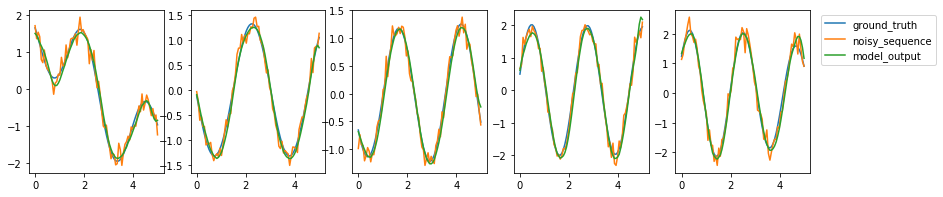

36.2284% of noise removed.
epoch: 41, train loss:5.017428398132324
epoch: 41, validation loss:49.427734375
epoch: 42, train loss:5.095887184143066
epoch: 42, validation loss:44.985145568847656
epoch: 43, train loss:2.8997325897216797
epoch: 43, validation loss:42.3437385559082
epoch: 44, train loss:2.2918150424957275
epoch: 44, validation loss:42.60071563720703
epoch: 45, train loss:2.936659812927246
epoch: 45, validation loss:46.74457550048828
epoch: 46, train loss:2.9032797813415527
epoch: 46, validation loss:38.180091857910156
epoch: 47, train loss:2.5808627605438232
epoch: 47, validation loss:47.67718505859375
epoch: 48, train loss:2.499546766281128
epoch: 48, validation loss:38.21707534790039
epoch: 49, train loss:2.4170408248901367
epoch: 49, validation loss:36.73197937011719
epoch: 50, train loss:2.335022449493408
epoch: 50, validation loss:35.633155822753906


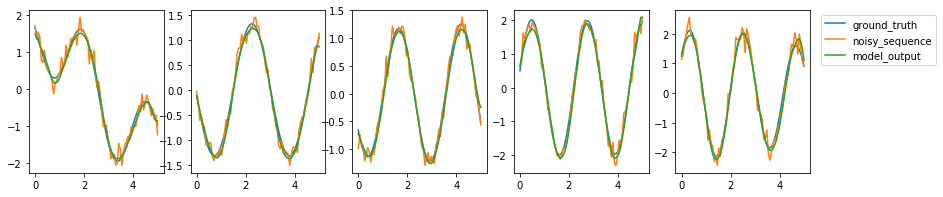

45.7400% of noise removed.
epoch: 51, train loss:2.5494792461395264
epoch: 51, validation loss:49.96094512939453
epoch: 52, train loss:2.9345874786376953
epoch: 52, validation loss:33.498775482177734
epoch: 53, train loss:2.2112340927124023
epoch: 53, validation loss:38.776634216308594
epoch: 54, train loss:2.030118942260742
epoch: 54, validation loss:45.250370025634766
epoch: 55, train loss:3.0593724250793457
epoch: 55, validation loss:40.24353790283203
epoch: 56, train loss:2.305973529815674
epoch: 56, validation loss:36.65922164916992
epoch: 57, train loss:2.1217849254608154
epoch: 57, validation loss:42.34117126464844
epoch: 58, train loss:2.3701534271240234
epoch: 58, validation loss:43.505516052246094
epoch: 59, train loss:2.807265043258667
epoch: 59, validation loss:42.23530578613281
epoch: 60, train loss:2.373528480529785
epoch: 60, validation loss:40.706687927246094


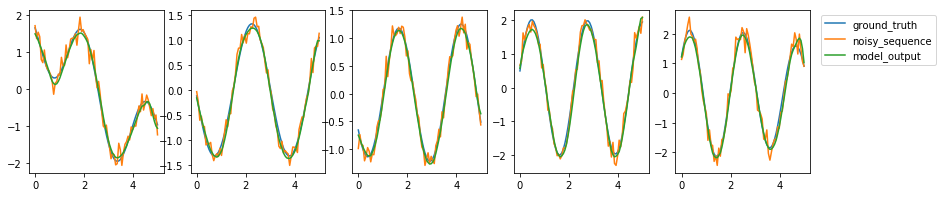

42.6465% of noise removed.
epoch: 61, train loss:9.570860862731934
epoch: 61, validation loss:58.680747985839844
epoch: 62, train loss:9.156325340270996
epoch: 62, validation loss:48.55946731567383
epoch: 63, train loss:6.231756687164307
epoch: 63, validation loss:61.037925720214844
epoch: 64, train loss:9.602324485778809
epoch: 64, validation loss:52.71852111816406
epoch: 65, train loss:6.435009479522705
epoch: 65, validation loss:47.6370964050293
epoch: 66, train loss:4.232222080230713
epoch: 66, validation loss:35.49525451660156
epoch: 67, train loss:3.2255873680114746
epoch: 67, validation loss:34.99555206298828
epoch: 68, train loss:2.62237811088562
epoch: 68, validation loss:36.2401008605957
epoch: 69, train loss:2.432182788848877
epoch: 69, validation loss:36.052276611328125
epoch: 70, train loss:2.3064002990722656
epoch: 70, validation loss:37.00435256958008


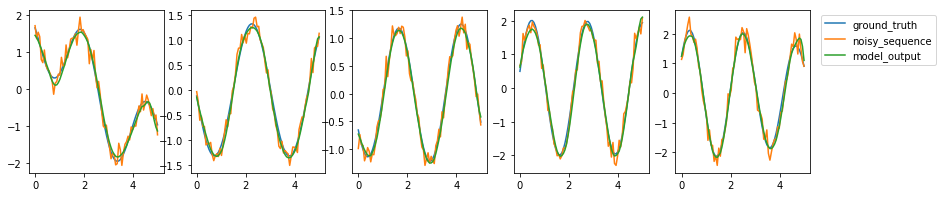

44.0337% of noise removed.
epoch: 71, train loss:1.988940715789795
epoch: 71, validation loss:35.68621826171875
epoch: 72, train loss:1.9880924224853516
epoch: 72, validation loss:36.88100051879883
epoch: 73, train loss:1.7359286546707153
epoch: 73, validation loss:36.59521484375
epoch: 74, train loss:1.7584853172302246
epoch: 74, validation loss:37.42330551147461
epoch: 75, train loss:1.602692723274231
epoch: 75, validation loss:37.23347854614258
epoch: 76, train loss:1.6097686290740967
epoch: 76, validation loss:37.50004577636719
epoch: 77, train loss:1.4480317831039429
epoch: 77, validation loss:36.79557800292969
epoch: 78, train loss:1.55190110206604
epoch: 78, validation loss:36.25129699707031
epoch: 79, train loss:1.5426788330078125
epoch: 79, validation loss:35.729854583740234
epoch: 80, train loss:1.8156927824020386
epoch: 80, validation loss:34.705318450927734


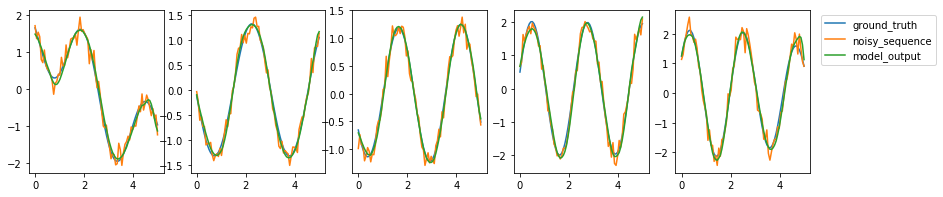

46.7838% of noise removed.
epoch: 81, train loss:2.038116216659546
epoch: 81, validation loss:35.97269821166992
epoch: 82, train loss:1.9698545932769775
epoch: 82, validation loss:37.2158317565918
epoch: 83, train loss:2.925076723098755
epoch: 83, validation loss:37.740135192871094
epoch: 84, train loss:2.436846971511841
epoch: 84, validation loss:38.23640060424805
epoch: 85, train loss:2.7139625549316406
epoch: 85, validation loss:35.932716369628906
epoch: 86, train loss:3.34889554977417
epoch: 86, validation loss:37.78867721557617
epoch: 87, train loss:2.691032886505127
epoch: 87, validation loss:38.54651641845703
epoch: 88, train loss:1.6908559799194336
epoch: 88, validation loss:36.12724685668945
epoch: 89, train loss:2.30743145942688
epoch: 89, validation loss:36.35297775268555
epoch: 90, train loss:2.18304443359375
epoch: 90, validation loss:32.76324462890625


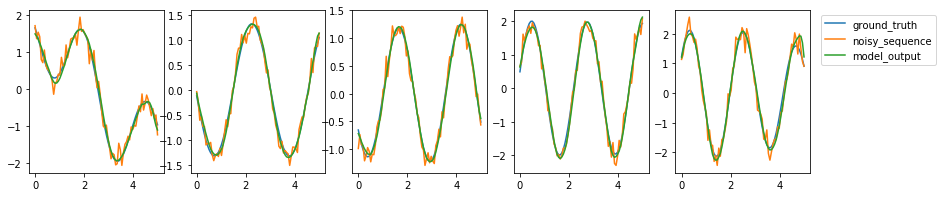

49.9176% of noise removed.
epoch: 91, train loss:3.196000099182129
epoch: 91, validation loss:33.12711715698242
epoch: 92, train loss:2.9492321014404297
epoch: 92, validation loss:31.802692413330078
epoch: 93, train loss:2.8992934226989746
epoch: 93, validation loss:31.64032554626465
epoch: 94, train loss:2.5552163124084473
epoch: 94, validation loss:31.302061080932617
epoch: 95, train loss:1.849823236465454
epoch: 95, validation loss:29.044513702392578
epoch: 96, train loss:1.8148937225341797
epoch: 96, validation loss:28.117956161499023
epoch: 97, train loss:1.4973875284194946
epoch: 97, validation loss:27.65610694885254
epoch: 98, train loss:1.393845796585083
epoch: 98, validation loss:27.470186233520508
epoch: 99, train loss:1.1219148635864258
epoch: 99, validation loss:27.308712005615234
epoch: 100, train loss:1.0037575960159302
epoch: 100, validation loss:27.142122268676758


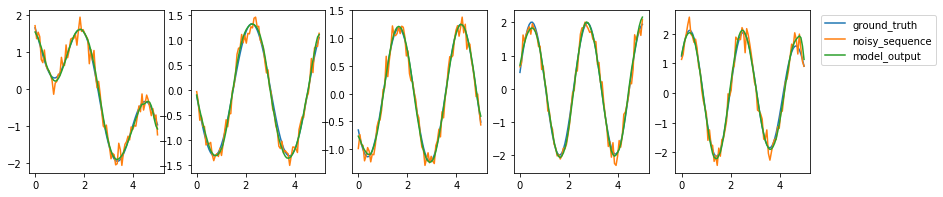

54.4133% of noise removed.
epoch: 101, train loss:0.8773745894432068
epoch: 101, validation loss:27.034204483032227
epoch: 102, train loss:0.8669868111610413
epoch: 102, validation loss:27.164764404296875
epoch: 103, train loss:0.7818058133125305
epoch: 103, validation loss:27.18138313293457
epoch: 104, train loss:0.8317928910255432
epoch: 104, validation loss:27.506689071655273
epoch: 105, train loss:0.723868727684021
epoch: 105, validation loss:27.554058074951172
epoch: 106, train loss:0.7785187363624573
epoch: 106, validation loss:27.521955490112305
epoch: 107, train loss:0.7416607141494751
epoch: 107, validation loss:27.331106185913086
epoch: 108, train loss:0.8253578543663025
epoch: 108, validation loss:27.128787994384766
epoch: 109, train loss:0.7752814888954163
epoch: 109, validation loss:26.79254150390625
epoch: 110, train loss:0.8144098520278931
epoch: 110, validation loss:26.8338623046875


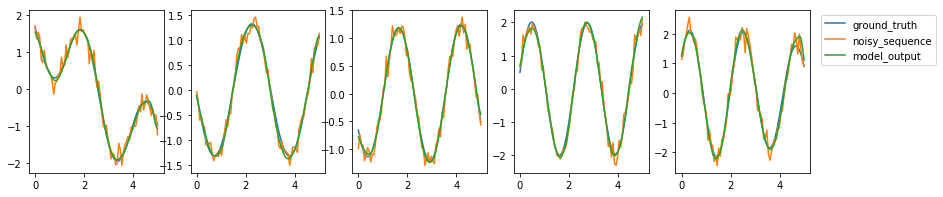

55.0655% of noise removed.
epoch: 111, train loss:0.8856523036956787
epoch: 111, validation loss:26.93511199951172
epoch: 112, train loss:0.8061333894729614
epoch: 112, validation loss:27.256254196166992
epoch: 113, train loss:0.8283319473266602
epoch: 113, validation loss:27.697629928588867
epoch: 114, train loss:0.743207573890686
epoch: 114, validation loss:27.786714553833008
epoch: 115, train loss:0.7338468432426453
epoch: 115, validation loss:28.238618850708008
epoch: 116, train loss:0.6963537931442261
epoch: 116, validation loss:28.199962615966797
epoch: 117, train loss:0.689049243927002
epoch: 117, validation loss:28.738327026367188
epoch: 118, train loss:0.6916951537132263
epoch: 118, validation loss:29.201889038085938
epoch: 119, train loss:0.6822202205657959
epoch: 119, validation loss:29.598072052001953
epoch: 120, train loss:0.6703262329101562
epoch: 120, validation loss:29.609912872314453


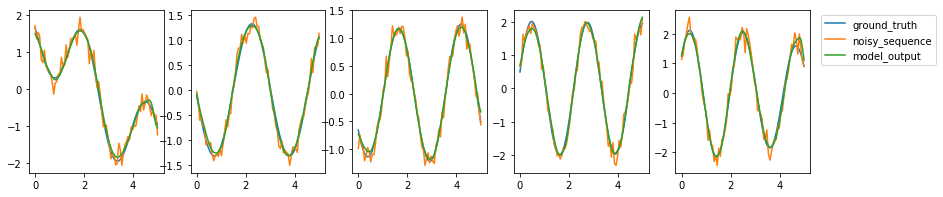

51.3036% of noise removed.
epoch: 121, train loss:0.6575253009796143
epoch: 121, validation loss:28.982566833496094
epoch: 122, train loss:0.6506474018096924
epoch: 122, validation loss:27.952953338623047
epoch: 123, train loss:0.6655580401420593
epoch: 123, validation loss:26.922771453857422
epoch: 124, train loss:0.6781233549118042
epoch: 124, validation loss:26.337718963623047
epoch: 125, train loss:0.6773473620414734
epoch: 125, validation loss:26.157001495361328
epoch: 126, train loss:0.6655317544937134
epoch: 126, validation loss:26.11855697631836
epoch: 127, train loss:0.6552048921585083
epoch: 127, validation loss:26.106945037841797
epoch: 128, train loss:0.6442215442657471
epoch: 128, validation loss:26.0704402923584
epoch: 129, train loss:0.6322301626205444
epoch: 129, validation loss:25.998205184936523
epoch: 130, train loss:0.6215415596961975
epoch: 130, validation loss:25.903797149658203


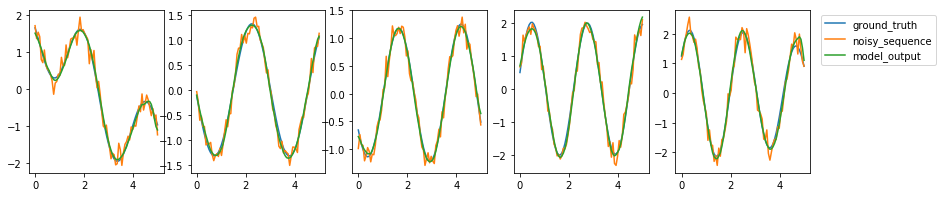

55.5795% of noise removed.
epoch: 131, train loss:0.6141335368156433
epoch: 131, validation loss:25.817277908325195
epoch: 132, train loss:0.6098698377609253
epoch: 132, validation loss:25.755199432373047
epoch: 133, train loss:0.6078794598579407
epoch: 133, validation loss:25.72004508972168
epoch: 134, train loss:0.6073713302612305
epoch: 134, validation loss:25.70697021484375
epoch: 135, train loss:0.6073675155639648
epoch: 135, validation loss:25.70054817199707
epoch: 136, train loss:0.6074007749557495
epoch: 136, validation loss:25.693008422851562
epoch: 137, train loss:0.6074106693267822
epoch: 137, validation loss:25.68705940246582
epoch: 138, train loss:0.607394814491272
epoch: 138, validation loss:25.683006286621094
epoch: 139, train loss:0.60736083984375
epoch: 139, validation loss:25.680505752563477
epoch: 140, train loss:0.6073076725006104
epoch: 140, validation loss:25.679227828979492


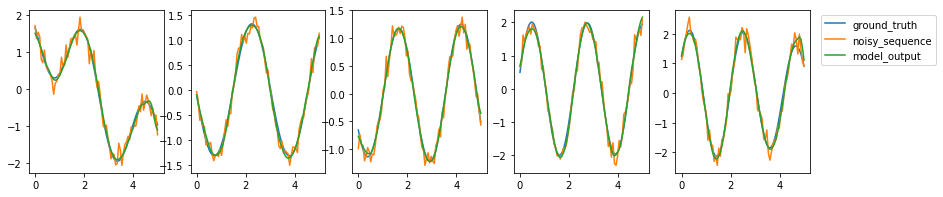

55.6053% of noise removed.
epoch: 0, train loss:893.0479125976562
epoch: 0, validation loss:1753.487060546875


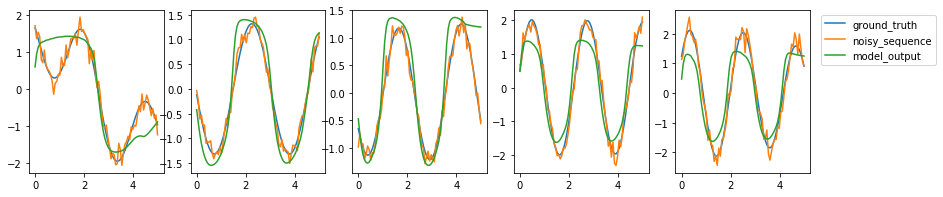

-335.2983% of noise removed.
epoch: 1, train loss:203.11212158203125
epoch: 1, validation loss:797.4767456054688
epoch: 2, train loss:130.72482299804688
epoch: 2, validation loss:377.0281677246094
epoch: 3, train loss:48.044891357421875
epoch: 3, validation loss:242.29066467285156
epoch: 4, train loss:37.864173889160156
epoch: 4, validation loss:131.5597381591797
epoch: 5, train loss:18.855762481689453
epoch: 5, validation loss:182.12193298339844
epoch: 6, train loss:26.85692024230957
epoch: 6, validation loss:99.84791564941406
epoch: 7, train loss:17.51674461364746
epoch: 7, validation loss:99.73816680908203
epoch: 8, train loss:18.937984466552734
epoch: 8, validation loss:156.5765380859375
epoch: 9, train loss:24.578079223632812
epoch: 9, validation loss:71.80207061767578
epoch: 10, train loss:17.924766540527344
epoch: 10, validation loss:105.83808135986328


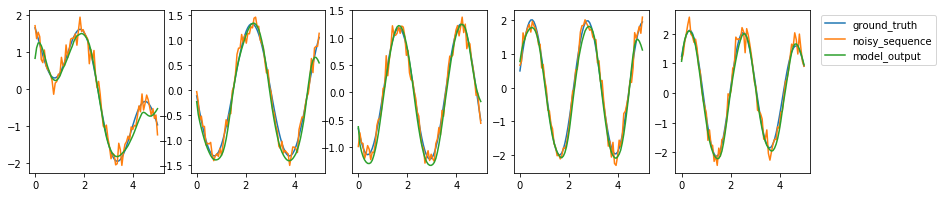

4.5284% of noise removed.
epoch: 11, train loss:11.612465858459473
epoch: 11, validation loss:73.61016082763672
epoch: 12, train loss:14.665665626525879
epoch: 12, validation loss:97.98966217041016
epoch: 13, train loss:18.300071716308594
epoch: 13, validation loss:109.43508911132812
epoch: 14, train loss:18.740455627441406
epoch: 14, validation loss:162.0956268310547
epoch: 15, train loss:21.44923210144043
epoch: 15, validation loss:124.79552459716797
epoch: 16, train loss:18.902385711669922
epoch: 16, validation loss:99.2033920288086
epoch: 17, train loss:15.114794731140137
epoch: 17, validation loss:109.16128540039062
epoch: 18, train loss:21.833415985107422
epoch: 18, validation loss:112.64038848876953
epoch: 19, train loss:10.789453506469727
epoch: 19, validation loss:74.26683044433594
epoch: 20, train loss:8.867934226989746
epoch: 20, validation loss:65.91680145263672


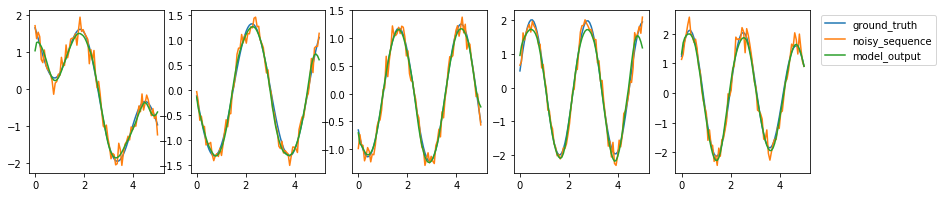

35.5759% of noise removed.
epoch: 21, train loss:9.812660217285156
epoch: 21, validation loss:56.6208610534668
epoch: 22, train loss:8.632538795471191
epoch: 22, validation loss:71.68673706054688
epoch: 23, train loss:8.507019996643066
epoch: 23, validation loss:73.2774429321289
epoch: 24, train loss:8.165355682373047
epoch: 24, validation loss:63.73074722290039
epoch: 25, train loss:10.78609848022461
epoch: 25, validation loss:76.2311782836914
epoch: 26, train loss:10.423556327819824
epoch: 26, validation loss:60.33087158203125
epoch: 27, train loss:6.928003787994385
epoch: 27, validation loss:42.73591995239258
epoch: 28, train loss:9.705599784851074
epoch: 28, validation loss:50.19099426269531
epoch: 29, train loss:6.387269496917725
epoch: 29, validation loss:42.29378128051758
epoch: 30, train loss:9.989767074584961
epoch: 30, validation loss:44.70284652709961


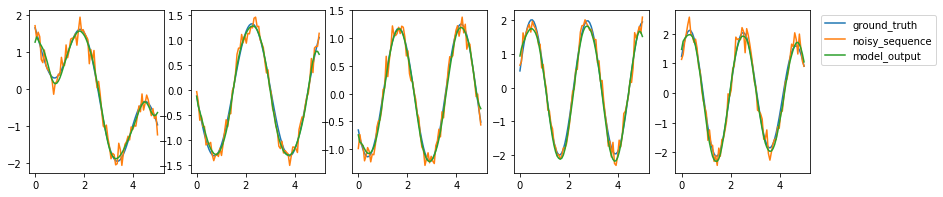

42.3343% of noise removed.
epoch: 31, train loss:6.459470748901367
epoch: 31, validation loss:43.445438385009766
epoch: 32, train loss:8.33991527557373
epoch: 32, validation loss:41.334381103515625
epoch: 33, train loss:6.410489559173584
epoch: 33, validation loss:56.536834716796875
epoch: 34, train loss:6.893190860748291
epoch: 34, validation loss:38.958587646484375
epoch: 35, train loss:7.042341232299805
epoch: 35, validation loss:47.913394927978516
epoch: 36, train loss:7.512067794799805
epoch: 36, validation loss:37.0830192565918
epoch: 37, train loss:7.074855327606201
epoch: 37, validation loss:43.54984664916992
epoch: 38, train loss:8.41735553741455
epoch: 38, validation loss:37.21271896362305
epoch: 39, train loss:7.387815475463867
epoch: 39, validation loss:37.89729690551758
epoch: 40, train loss:6.15205717086792
epoch: 40, validation loss:33.908836364746094


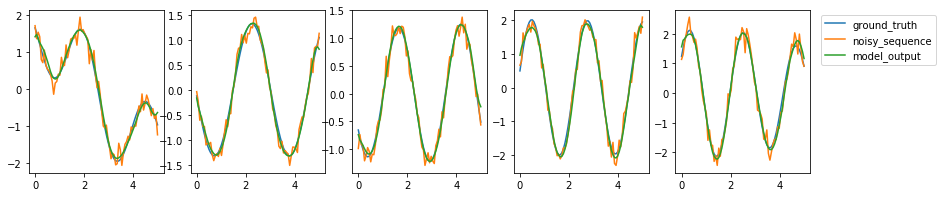

47.3879% of noise removed.
epoch: 41, train loss:5.0780558586120605
epoch: 41, validation loss:33.924808502197266
epoch: 42, train loss:4.140330791473389
epoch: 42, validation loss:30.506134033203125
epoch: 43, train loss:4.306784629821777
epoch: 43, validation loss:32.17271041870117
epoch: 44, train loss:4.087667942047119
epoch: 44, validation loss:37.38075256347656
epoch: 45, train loss:3.5417463779449463
epoch: 45, validation loss:46.35865020751953
epoch: 46, train loss:4.8866472244262695
epoch: 46, validation loss:44.18301010131836
epoch: 47, train loss:5.6768951416015625
epoch: 47, validation loss:39.47785568237305
epoch: 48, train loss:5.577743053436279
epoch: 48, validation loss:34.78833770751953
epoch: 49, train loss:5.264692306518555
epoch: 49, validation loss:30.435869216918945
epoch: 50, train loss:4.376779556274414
epoch: 50, validation loss:29.60940933227539


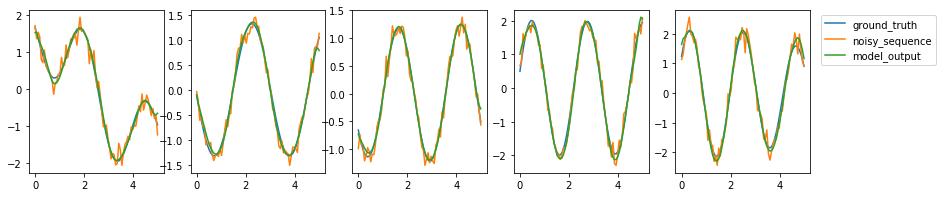

51.4533% of noise removed.
epoch: 51, train loss:3.8467111587524414
epoch: 51, validation loss:29.582448959350586
epoch: 52, train loss:3.537865161895752
epoch: 52, validation loss:28.467084884643555
epoch: 53, train loss:3.273742198944092
epoch: 53, validation loss:27.12436294555664
epoch: 54, train loss:3.1071362495422363
epoch: 54, validation loss:27.296415328979492
epoch: 55, train loss:2.9708092212677
epoch: 55, validation loss:27.480777740478516
epoch: 56, train loss:3.070260763168335
epoch: 56, validation loss:28.119979858398438
epoch: 57, train loss:3.0778446197509766
epoch: 57, validation loss:28.65262222290039
epoch: 58, train loss:2.9737186431884766
epoch: 58, validation loss:29.631515502929688
epoch: 59, train loss:2.7593653202056885
epoch: 59, validation loss:31.324737548828125
epoch: 60, train loss:2.6489739418029785
epoch: 60, validation loss:33.72514343261719


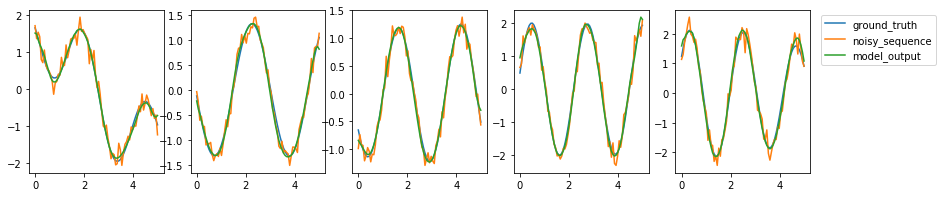

49.1058% of noise removed.
epoch: 61, train loss:2.7691800594329834
epoch: 61, validation loss:36.375244140625
epoch: 62, train loss:2.976816177368164
epoch: 62, validation loss:37.496212005615234
epoch: 63, train loss:3.3379006385803223
epoch: 63, validation loss:36.45279312133789
epoch: 64, train loss:3.344743490219116
epoch: 64, validation loss:33.84776306152344
epoch: 65, train loss:2.9250118732452393
epoch: 65, validation loss:29.59408950805664
epoch: 66, train loss:2.5562174320220947
epoch: 66, validation loss:27.304508209228516
epoch: 67, train loss:2.4571285247802734
epoch: 67, validation loss:27.436094284057617
epoch: 68, train loss:2.459829807281494
epoch: 68, validation loss:28.058683395385742
epoch: 69, train loss:2.4132821559906006
epoch: 69, validation loss:27.654260635375977
epoch: 70, train loss:2.547201633453369
epoch: 70, validation loss:27.43952178955078


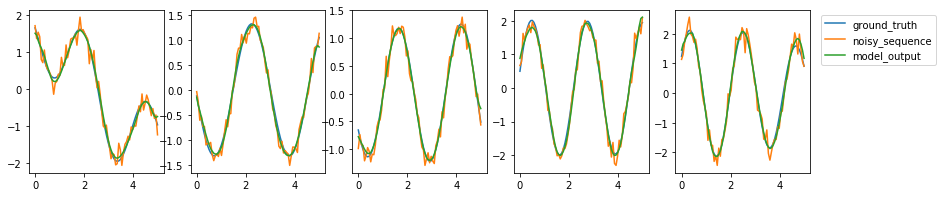

54.4947% of noise removed.
epoch: 71, train loss:2.738718032836914
epoch: 71, validation loss:28.39909553527832
epoch: 72, train loss:2.7009856700897217
epoch: 72, validation loss:29.649194717407227
epoch: 73, train loss:2.6015851497650146
epoch: 73, validation loss:30.32215690612793
epoch: 74, train loss:2.497515916824341
epoch: 74, validation loss:30.784683227539062
epoch: 75, train loss:2.417234182357788
epoch: 75, validation loss:31.952381134033203
epoch: 76, train loss:2.3433172702789307
epoch: 76, validation loss:33.829444885253906
epoch: 77, train loss:2.2430784702301025
epoch: 77, validation loss:34.10814666748047
epoch: 78, train loss:2.3306937217712402
epoch: 78, validation loss:30.57159423828125
epoch: 79, train loss:2.628350257873535
epoch: 79, validation loss:27.041290283203125
epoch: 80, train loss:2.4004392623901367
epoch: 80, validation loss:26.48406219482422


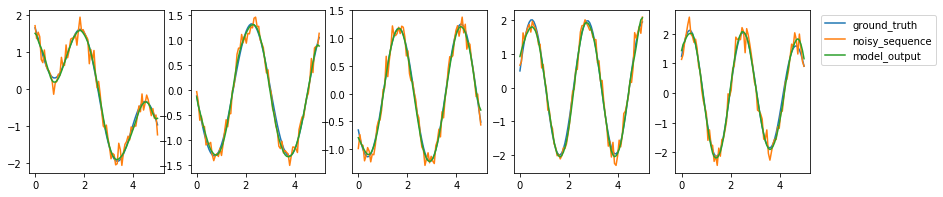

54.3254% of noise removed.
epoch: 81, train loss:2.1319329738616943
epoch: 81, validation loss:26.179384231567383
epoch: 82, train loss:2.064603805541992
epoch: 82, validation loss:26.251802444458008
epoch: 83, train loss:2.041182279586792
epoch: 83, validation loss:26.374011993408203
epoch: 84, train loss:2.0152790546417236
epoch: 84, validation loss:26.522024154663086
epoch: 85, train loss:1.978347659111023
epoch: 85, validation loss:26.508005142211914
epoch: 86, train loss:1.937282681465149
epoch: 86, validation loss:26.223953247070312
epoch: 87, train loss:1.9103102684020996
epoch: 87, validation loss:25.850536346435547
epoch: 88, train loss:1.90645170211792
epoch: 88, validation loss:25.609649658203125
epoch: 89, train loss:1.8998212814331055
epoch: 89, validation loss:25.5511531829834
epoch: 90, train loss:1.8905901908874512
epoch: 90, validation loss:25.5698184967041


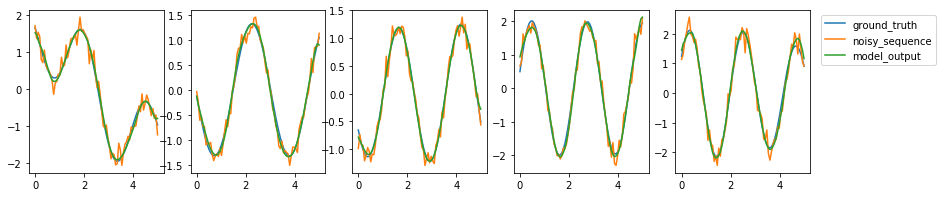

55.8682% of noise removed.
epoch: 91, train loss:1.8905467987060547
epoch: 91, validation loss:25.60430908203125
epoch: 92, train loss:1.8915191888809204
epoch: 92, validation loss:25.649372100830078
epoch: 93, train loss:1.8830878734588623
epoch: 93, validation loss:25.625160217285156
epoch: 94, train loss:1.8771427869796753
epoch: 94, validation loss:25.570199966430664
epoch: 95, train loss:1.8750076293945312
epoch: 95, validation loss:25.555173873901367
epoch: 96, train loss:1.8724393844604492
epoch: 96, validation loss:25.541759490966797
epoch: 97, train loss:1.8705700635910034
epoch: 97, validation loss:25.533523559570312
epoch: 98, train loss:1.869173288345337
epoch: 98, validation loss:25.52781105041504
epoch: 99, train loss:1.868196725845337
epoch: 99, validation loss:25.524534225463867
epoch: 100, train loss:1.8675471544265747
epoch: 100, validation loss:25.522844314575195


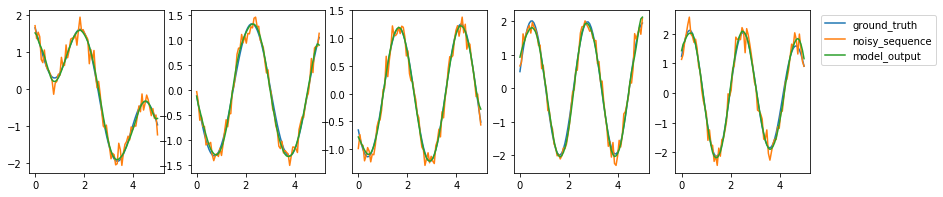

55.7823% of noise removed.


In [11]:
# don't forget to create a new model each time!
# START TODO #############

# Model 1 Bath size =20    %52 removed
batch_size = 20
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

#Model 2 bathch size 5, num_epoch = 150  56.99%

batch_size = 5
num_epochs = 141


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)

#Model 3 lr  = 0.02
 
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)



**Feedback (3):** It was a great exercise to learn how to implement a network using pytorch. Additionally, we saw the results and tried to improve them, so overall it was a really educational exercise. We spent 8 hours for this part.